In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee as mc
from scipy import stats

%matplotlib inline

In [137]:
def createMockCluster(rin,rout,nmean,k,smax,m,vmean,threeD=False):
    ntot = np.random.poisson(lam=nmean)
    
    nu0 = ntot/(4*np.pi*(np.log(rout/rin))) if k==3. else ntot*(3.-k)/(4*np.pi*(rout**(3.-k)-rin**(3.-k)))
    #rho = 4*np.pi*nu0*np.random.uniform(low=rin,high=rout,size=ntot)**(2.-k)
    rho = np.power(np.random.uniform(4*np.pi*nu0*rin**(2.-k),4*np.pi*nu0*rout**(2.-k),size=ntot)/(4*np.pi*nu0),1./(2-k))
    phi = np.random.uniform(0.,2*np.pi,ntot)
    theta = np.arccos(np.random.uniform(-1,1,ntot))
    
    x = rho*np.sin(theta)*np.cos(phi)
    y = rho*np.sin(theta)*np.sin(phi)
    
    vobs = np.array([np.random.normal(loc=vmean,scale=(1/np.sqrt(3))*smax/(i**m)) for i in rho])
    
    if threeD:
        z = rho*np.cos(theta)
        return pd.DataFrame(np.hstack((x.reshape((ntot,1)),y.reshape((ntot,1)),z.reshape((ntot,1)),\
                                      vobs.reshape((ntot,1)),rho.reshape((ntot,1)))),columns=['x','y','z','vobs','rho'])
    else:
        r = np.sqrt(np.power(x,2.)+np.power(y,2.))
        return pd.DataFrame(np.hstack((r.reshape((ntot,1)),vobs.reshape((ntot,1)))),columns=['r','vobs'])

In [138]:
#load data

data=pd.read_csv('continuousMock0.csv')
#data.rename(columns={'Unnamed: 0':'id','0':'origAnn','1':'x','2':'y','3':'z','4':'vobs'},inplace=True)
#
#data['r'] = np.power(np.power(data['x'],2.)+np.power(data['y'],2.),0.5)

def defineAnnuli(r,nAnn):
    return np.append(0.,np.sort(r)[np.linspace(0,len(r)-1,nAnn).astype(int)][1:])

nAnn = 10
annuli = defineAnnuli(data['r'],nAnn)

print annuli

[   0.            0.79312162    0.99200463    1.19653973    1.44488527
    1.78940227    2.26611172    3.40412606    6.47930261  488.39105307]


In [139]:
def labelGalaxies(data,annuli):
    #adds a column to data indicating the galaxy's membership in an annulus
    bla = np.zeros(len(data['r']))
    for i in range(len(annuli)-1):
        bla += i*np.array(np.logical_and(data['r']>annuli[i],data['r']<=annuli[i+1]).astype(int))
    return bla

def galInAnn(data,annuli):
    #calculates the number of galaxies in all the annuli
    return np.array([(data['annuli']==i).sum() for i in range(len(annuli)-1)])

def sigInAnn(data,annuli):
    return [np.std(data['vobs'][data['annuli']==i],ddof=1) for i in range(len(annuli)-1)]

def getProfiles(annuli,rin,rout,nmean,k,smax,m,vmean):
    mock = createMockCluster(rin,rout,nmean,k,smax,m,vmean)
    mock['annuli'] = labelGalaxies(mock,annuli)
    return galInAnn(mock,annuli),sigInAnn(mock,annuli)

In [140]:
data['annuli'] = labelGalaxies(data,annuli)

nObs = galInAnn(data,annuli)
sObs = sigInAnn(data,annuli)

vMean = np.mean(data['vobs'])

print nObs,sObs

[112 111 112 111 112 111 112 111 112] [540.6459164824956, 535.2118446805213, 479.94459127400813, 478.113651156466, 505.3241440991127, 495.1272316797748, 450.3661464577093, 348.32470090040425, 383.5558324031583]


In [142]:
#all log likelihoods

#make a table of log(n!)-s for n=1,...
#factorialTable = np.cumsum(np.append(0,[np.log(i) for i in range(1,len(data['r']))]))

def logPriorK(k):
    #starting gaussian
    #nu0 = 3. #mean prior density index
    #sigma = 1.
    return 0.0
    #return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)

def logPriorM(m):
    #starting gaussian
    #nu0 = -.2 #mean prior sigma index
    #sigma = 0.1
    return 0.0
    #return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)

def logPriorSigma0(sigma0):
    #starting gaussian
    #nu0 = 1000 #mean prior sigma index
    #sigma = 500
    return 0.0
    #return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)

def logPriorNmean(nmean):
    return 0.0

def logPriorNtot(ntot):
    return 0.0

def logPriorVmean(vmean):
    return 0.0

def logLikelihoodNu(prediction,data):
    return np.sum(data*np.log(prediction)-prediction)

def logLikelihoodSigma(vObs,vPred,nPred):
    # distribution of variances is chisq, as shown, for example, at
    # https://onlinecourses.science.psu.edu/stat414/node/174
    return np.sum(np.log(stats.chi2.pdf((nPred-1.)*np.power(vObs,2.)/np.power(vPred,2.),nPred-1)))

def logPosterior(params,annuli,rin,rout,nObs,sObs):
    nmean,k,smax,m,vmean = params
    nPred,sPred = getProfiles(annuli,rin,rout,50*nmean,k,smax,m,vmean)
    if not np.all(nPred>0.): return -np.inf
    nPred/=50
    return logPriorK(k)+logPriorM(m)+logPriorSigma0(smax)+logPriorNmean(nmean)+logPriorVmean(vmean)+\
           logLikelihoodNu(nPred,nObs)+logLikelihoodSigma(sObs,sPred,nPred)

In [143]:
ntot=1000
bla1,bla2 = getProfiles(annuli,1,1000,50*ntot,3,1000,0.2,0)

bla1/=50

print bla1
print bla2

[117  90 130 113 105  91 114 107 119]
[541.420313701401, 545.142251912514, 549.6650631758216, 530.8156515919305, 496.2282686299781, 487.33888536604763, 455.9480348657617, 413.7780332086469, 319.5090740033427]


In [144]:
nwalkers = 30
ndim = 5

#initial = np.tile(np.array([np.random.normal(1000,100),np.random.normal(3,0.3),np.random.normal(1000,100),np.random.normal(0.2,0.02)]),10).reshape((nwalkers,ndim))
initial = np.array([np.random.normal(1000,100),np.random.normal(3,0.3),\
                    np.random.normal(1000,100),np.random.normal(0.2,0.02),\
                    np.random.normal(0,100)])

for i in range(nwalkers-1):
    initial=np.vstack((initial,np.array([np.random.normal(1000,100),np.random.normal(3,0.3),\
                    np.random.normal(1000,100),np.random.normal(0.2,0.02),np.random.normal(0,100)])))

#for i in range(nwalkers):
#    for j in range(ndim):
#        initial[i,j]+=np.random.normal()


In [145]:
rin = 1
rout = 1000
sampler = mc.EnsembleSampler(nwalkers, ndim, logPosterior, args=[annuli,rin,rout,nObs,sObs],threads=4)

#p0 = np.array([1000,3,1000,0.2])reshape((nwalkers,ndim))

#pos, prob, state = sampler.run_mcmc(initial, 5)


In [146]:
pos, prob, state = sampler.run_mcmc(initial, 100)

(3000, 5)


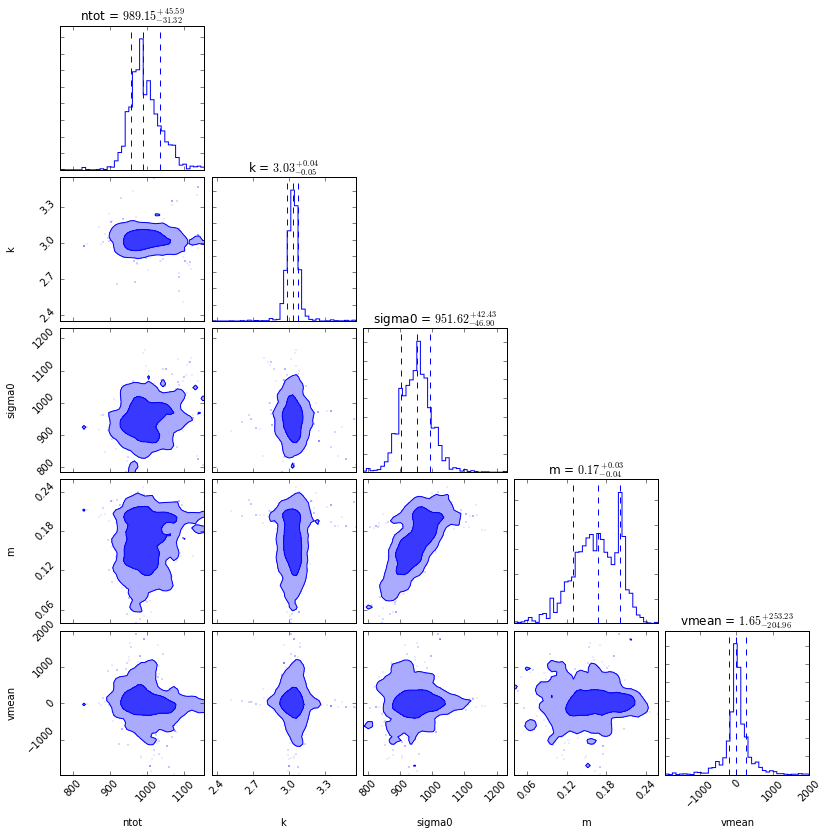

In [148]:
print sampler.flatchain.shape

import corner
corner.corner(sampler.flatchain, labels=['ntot','k','sigma0','m','vmean'],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=40, smooth=1.0);
plt.show()

In [164]:
print sampler.flatchain[0]

[  9.66353694e+02   3.16658603e+00   9.63125173e+02   1.95394050e-01
   4.46885569e+01]


In [ ]:
radii = np.logspace(0,3,20)

def generateMassProfile(radii,sigma0,m,k):
    return -radii*(sigma0*radii**(-m))**2*(-k-m)

for i in sampler.flatchain:
    plt.plot(radii,generateMassProfile(radii,i[2],i[3],i[1]),alpha=0.01)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius')
plt.ylabel('mass (arb.units)')
    

In [ ]:
1